# Parse Experimental Results & Generate Latex Tables

<a id='toc'/>

In [2]:
import os, pickle, types
import numpy as np
import pandas as pd
import cython

In [3]:
data_dir = 'data'

In [4]:
dat_suffix = ['Edin', 'Glas', 'Melb', 'Osak', 'Toro']
dat_names = ['Edinburgh', 'Glasgow', 'Melbourne', 'Osaka', 'Toronto']

In [5]:
methods_all = ['\\textsc{Random}', '\\textsc{PersTour}', '\\textsc{PersTour-L}', '\\textsc{PoiPopularity}', \
               '\\textsc{PoiRank}', '\\textsc{Markov}', '\\textsc{MarkovPath}', \
               '\\textsc{Rank+Markov}', '\\textsc{Rank+MarkovPath}']

## Latex Table for Recommendation Results

Generate results filenames.

In [6]:
def gen_fname(dat_ix):
    assert(0 <= dat_ix < len(dat_suffix))
    
    suffix = dat_suffix[dat_ix] + '.pkl'
    
    frank = os.path.join(data_dir, 'rank-' + suffix)
    ftran = os.path.join(data_dir, 'tran-' + suffix)
    fcomb = os.path.join(data_dir, 'comb-' + suffix)
    frand = os.path.join(data_dir, 'rand-' + suffix)
    fijcai = os.path.join(data_dir, 'ijcai-' + dat_suffix[dat_ix] + '.pkl')
    return frank, ftran, fcomb, frand, fijcai

Compute the F1 score for recommended trajectory.

In [7]:
def calc_F1(traj_act, traj_rec, noloop=False):
    '''Compute recall, precision and F1 for recommended trajectories'''
    assert(isinstance(noloop, bool))
    assert(len(traj_act) > 0)
    assert(len(traj_rec) > 0)
    
    if noloop == True:
        intersize = len(set(traj_act) & set(traj_rec))
    else:
        match_tags = np.zeros(len(traj_act), dtype=np.bool)
        for poi in traj_rec:
            for j in range(len(traj_act)):
                if match_tags[j] == False and poi == traj_act[j]:
                    match_tags[j] = True
                    break
        intersize = np.nonzero(match_tags)[0].shape[0]
        
    recall = intersize / len(traj_act)
    precision = intersize / len(traj_rec)
    F1 = 2 * precision * recall / (precision + recall)
    return F1

Compute the pairs-F1 score for recommended trajectory.

In [8]:
# %load_ext Cython

In [9]:
import numpy as np

def calc_pairsF1(y, y_hat):
    assert(len(y) > 0)
    assert(len(y) == len(set(y))) # no loops in y
    n = len(y)
    nr = len(y_hat)
    n0 = n*(n-1) // 2
    n0r = nr*(nr-1) // 2
    
    # y determines the correct visiting order
    order_dict = dict()
    for i in range(n):
        order_dict[y[i]] = i
        
    nc = 0
    for i in range(nr):
        poi1 = y_hat[i]
        for j in range(i+1, nr):
            poi2 = y_hat[j]
            if poi1 in order_dict and poi2 in order_dict and poi1 != poi2:
                if order_dict[poi1] < order_dict[poi2]: nc += 1

    precision = (1.0 * nc) / (1.0 * n0r)
    recall = (1.0 * nc) / (1.0 * n0)
    if nc == 0:
        F1 = 0
    else:
        F1 = 2. * precision * recall / (precision + recall)
    return F1

Load results data.

In [10]:
def load_results(dat_ix):
    assert(0 <= dat_ix < len(dat_suffix))
    
    frank, ftran, fcomb, frand, fijcai = gen_fname(dat_ix)
    #print(frank)
    assert(os.path.exists(frank))
    #print(ftran)
    assert(os.path.exists(ftran))
    #print(fcomb)
    assert(os.path.exists(fcomb))
    #print(frand)
    assert(os.path.exists(frand))
    #print(fijcai)
    assert(os.path.exists(fijcai))

    # load results data
    recdict_rank = pickle.load(open(frank, 'rb'))
    recdict_tran = pickle.load(open(ftran, 'rb'))
    recdict_comb = pickle.load(open(fcomb, 'rb'))
    recdict_rand = pickle.load(open(frand, 'rb'))
    recdict_ijcai = pickle.load(open(fijcai, 'rb'))
    
    return recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai

In [29]:
recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai=load_results(2)
recdict_rank

{14: {'REAL': [81, 75, 56, 57, 78, 55],
  'REC_POP': [81, 71, 82, 32, 50, 55],
  'REC_FEATURE': [81, 71, 82, 50, 44, 55]},
 63: {'REAL': [40, 17, 14],
  'REC_POP': [40, 71, 14],
  'REC_FEATURE': [40, 71, 14]},
 64: {'REAL': [40, 2, 9, 32],
  'REC_POP': [40, 71, 82, 32],
  'REC_FEATURE': [40, 71, 82, 32]},
 78: {'REAL': [16, 41, 22],
  'REC_POP': [16, 71, 22],
  'REC_FEATURE': [16, 84, 22]},
 129: {'REAL': [23, 40, 3],
  'REC_POP': [23, 71, 3],
  'REC_FEATURE': [23, 71, 3]},
 143: {'REAL': [41, 36, 55, 71, 81, 50],
  'REC_POP': [41, 71, 82, 32, 35, 50],
  'REC_FEATURE': [41, 71, 82, 35, 32, 50]},
 145: {'REAL': [82, 50, 15, 70, 69, 48, 40, 84],
  'REC_POP': [82, 71, 32, 50, 35, 9, 81, 84],
  'REC_FEATURE': [82, 71, 50, 81, 35, 32, 9, 84]},
 147: {'REAL': [41, 22, 21, 84],
  'REC_POP': [41, 71, 82, 84],
  'REC_FEATURE': [41, 32, 71, 84]},
 150: {'REAL': [71, 67, 81, 27],
  'REC_POP': [71, 82, 32, 27],
  'REC_FEATURE': [71, 82, 50, 27]},
 166: {'REAL': [9, 44, 81],
  'REC_POP': [9, 71, 81

Calculate F1-scores from loaded results.

In [15]:
def calc_metrics(recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai, func):
    assert(isinstance(func, types.FunctionType) or isinstance(func, types.BuiltinFunctionType))
    
    # deal with missing values: 
    # get rid of recommendation that not all method are successful, due to ILP timeout.
    assert(np.all(sorted(recdict_rank.keys()) == sorted(recdict_tran.keys())))
    assert(np.all(sorted(recdict_rank.keys()) == sorted(recdict_comb.keys())))
    
    keys_all = sorted(recdict_ijcai.keys() & recdict_rank.keys())
    
    rank1 = []; rank2 = []
    for key in keys_all:
        rank1.append(func(recdict_rank[key]['REAL'], recdict_rank[key]['REC_POP']))
        rank2.append(func(recdict_rank[key]['REAL'], recdict_rank[key]['REC_FEATURE']))
    
    tran1 = []; tran2 = []
    for key in keys_all:
        tran1.append(func(recdict_tran[key]['REAL'], recdict_tran[key]['REC_DP']))
        tran2.append(func(recdict_tran[key]['REAL'], recdict_tran[key]['REC_ILP']))

    comb1 = []; comb2 = []
    for key in keys_all:
        comb1.append(func(recdict_comb[key]['REAL'], recdict_comb[key]['REC_DP']))
        comb2.append(func(recdict_comb[key]['REAL'], recdict_comb[key]['REC_ILP']))
            
    rand = []
    for key in keys_all:
        rand.append(func(recdict_rand[key]['REAL'], recdict_rand[key]['REC_RAND']))
    
    ijcai05T = []; ijcai05L = []
    for key in keys_all:
        ijcai05T.append(func(recdict_ijcai[key]['REAL'], recdict_ijcai[key]['REC05T']))
        ijcai05L.append(func(recdict_ijcai[key]['REAL'], recdict_ijcai[key]['REC05L']))
    
    metrics = [rand, ijcai05T, ijcai05L, rank1, rank2, tran1, tran2, comb1, comb2]
    means = [np.mean(x) for x in metrics]
    stds  = [np.std(x)  for x in metrics]
    
    return means, stds, metrics

393
[0.6666666666666666, 0.75, 0.6666666666666666, 0.6666666666666666, 0.5, 0.375, 0.5, 0.75, 0.6666666666666666, 0.4000000000000001, 0.5, 0.6666666666666666, 0.4000000000000001, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.4000000000000001, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.2857142857142857, 0.6666666666666666, 0.5714285714285714, 0.75, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.2222222222222222, 0.5, 0.20000000000000004, 1.0, 0.6666666666666666, 0.2857142857142857, 0.3333333333333333, 0.6666666666666666, 0.5, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6, 0.75, 0.6666666666666666, 0.5, 0.6666666666666666, 0.5, 0.3333333333333333, 0.375, 0.5, 0.6, 0.6666666666666666, 0.2857142857142857, 0.5, 0.25, 0.5, 0.6666666666666666, 0.666

/var/folders/rk/dg37j05d3rnd6phqd90g_zj40000gn/T/ipykernel_66371/3005200209.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  match_tags = np.zeros(len(traj_act), dtype=np.bool)


{'whiskers': [<matplotlib.lines.Line2D at 0x7fbf328e8f10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbf328f64f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fbf328e8c40>],
 'medians': [<matplotlib.lines.Line2D at 0x7fbf328f6a90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fbf328f6d60>],
 'means': []}

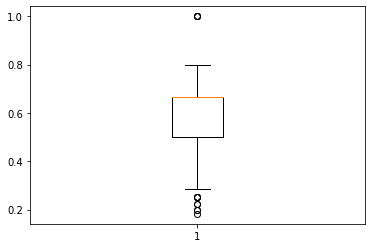

In [30]:
from matplotlib import pyplot as plt
means, stds, metrics=calc_metrics(recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai,calc_F1)
print(len(metrics[2]))
print(metrics[2])
plt.boxplot(metrics[2])


Generate Latex tables from calculated metrics.

In [24]:
def gen_latex_table(mean_df, std_df, ismax_df, ismax2nd_df, title, label):    
    strs = []
    strs.append('\\begin{table*}[t]\n')
    strs.append('\\caption{' + title + '}\n')
    strs.append('\\label{' + label + '}\n')
    strs.append('\\centering\n')
    strs.append('\\begin{tabular}{l|' + (mean_df.shape[1])*'c' + '} \\hline\n')
    for col in mean_df.columns:
        strs.append(' & ' + col)
    strs.append(' \\\\ \\hline\n')
    for ix in mean_df.index:
        for j in range(mean_df.shape[1]):
            if j == 0: strs.append(ix + ' ')
            jx = mean_df.columns[j]
            strs.append('& $')
            if ismax_df.loc[ix, jx] == True: strs.append('\\mathbf{')
            if ismax2nd_df.loc[ix, jx] == True: strs.append('\\mathit{')
            strs.append('%.3f' % mean_df.loc[ix, jx] + '\\pm' + '%.3f' % std_df.loc[ix, jx])
            if ismax_df.loc[ix, jx] == True or ismax2nd_df.loc[ix, jx] == True: strs.append('}')
            strs.append('$ ')
        strs.append('\\\\\n')
    strs.append('\\hline\n')
    strs.append('\\end{tabular}\n')
    strs.append('\\end{table*}\n')
    return ''.join(strs)

Generate evaluation data tables.

In [25]:
#func = calc_F1
func = calc_pairsF1

In [26]:
methods = methods_all.copy()

mean_df = pd.DataFrame(data=np.zeros((len(methods), len(dat_names)), dtype=float), \
                       columns=dat_names, index=methods)
std_df  = pd.DataFrame(data=np.zeros((len(methods), len(dat_names)), dtype=float), \
                       columns=dat_names, index=methods)

for dat_ix in range(len(dat_suffix)):
    recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai = load_results(dat_ix)
    means, stds = calc_metrics(recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai, func)
    assert(len(means) == len(stds) == len(methods))
    mean_df[dat_names[dat_ix]] = means
    std_df[dat_names[dat_ix]]  = stds

ismax_df = pd.DataFrame(data=np.zeros(mean_df.shape, dtype=bool), columns=mean_df.columns, index=mean_df.index)
ismax2nd_df = ismax_df.copy()
for col in ismax_df.columns:
    indices = (-mean_df[col]).argsort().values[:2]
    ismax_df.iloc[indices[0]][col] = True
    ismax2nd_df.iloc[indices[1]][col] = True

if func == calc_F1:
    title = '''Performance comparison on five datasets in terms of F$_1$ scores.
    The best method for each dataset (i.e., a column) is shown in bold, the second best is shown in italic.'''
    label = 'tab:f1'
else:
    title = '''Performance comparison on five datasets in terms of pairs-F$_1$ scores.
    The best method for each dataset (i.e., a column) is shown in bold, the second best is shown in italic.'''
    label = 'tab:pairf1'
strs = gen_latex_table(mean_df, std_df, ismax_df, ismax2nd_df, title, label)

print(strs)

\begin{table*}[t]
\caption{Performance comparison on five datasets in terms of pairs-F$_1$ scores.
    The best method for each dataset (i.e., a column) is shown in bold, the second best is shown in italic.}
\label{tab:pairf1}
\centering
\begin{tabular}{l|ccccc} \hline
 & Edinburgh & Glasgow & Melbourne & Osaka & Toronto \\ \hline
\textsc{Random} & $0.266\pm0.138$ & $0.298\pm0.136$ & $0.246\pm0.140$ & $0.315\pm0.127$ & $0.295\pm0.144$ \\
\textsc{PersTour} & $0.417\pm0.343$ & $\mathbf{0.643\pm0.366}$ & $0.216\pm0.265$ & $0.468\pm0.376$ & $0.504\pm0.354$ \\
\textsc{PersTour-L} & $0.359\pm0.207$ & $0.352\pm0.162$ & $0.266\pm0.140$ & $0.406\pm0.238$ & $0.333\pm0.163$ \\
\textsc{PoiPopularity} & $\mathit{0.436\pm0.259}$ & $0.507\pm0.298$ & $0.316\pm0.178$ & $0.365\pm0.190$ & $0.384\pm0.201$ \\
\textsc{PoiRank} & $0.432\pm0.250$ & $\mathit{0.552\pm0.313}$ & $0.336\pm0.198$ & $\mathbf{0.511\pm0.309}$ & $\mathbf{0.517\pm0.295}$ \\
\textsc{Markov} & $0.417\pm0.248$ & $0.495\pm0.296$ & $0.288\pm